## Importing Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error





# Loading Dataset

In [ ]:
try:
    train_df = pd.read_csv('/content/drive/MyDrive/AWIBI/train.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'car_prices.csv' was not found. Please check the file path.")

Data loaded successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploratory Data Analysis

In [ ]:
def plots(columns,ncols_for_subplot, df):
    ncols = ncols_for_subplot
    nrows = -(-len(columns) // ncols)  # ceiling division

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.scatterplot(x=col, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Price vs. {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Price')

    # hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
categorical_cols = train_df.select_dtypes(include='object').columns
numerical_cols = train_df.select_dtypes(exclude='object').columns

In [ ]:
def df_info(df):
  print("The Dataset Info")
  df.info()

  print("Statistics for numerical columns")
  print(df.describe())

  print("Statistics for categorical columns")
  print(df.describe(include='object'))

  print("Missing values per column")
  print(df.isnull().sum())

In [ ]:
df_info(train_df)

The Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB
Statistics for numerical columns
                  id     model_year         milage         price
count  188533.000000  188533.000000  188533.000000  1.885330e+05
mean    94266

In [ ]:
def exploratory_data_analysis(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price'], kde=True, bins=50)
    plt.title('Distribution of Car Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()


    # Visualizing the relationship between all numerical features and price
    print('Plotting numerical variables vs price')
    numerical_plot=plots(numerical_cols,2,df)


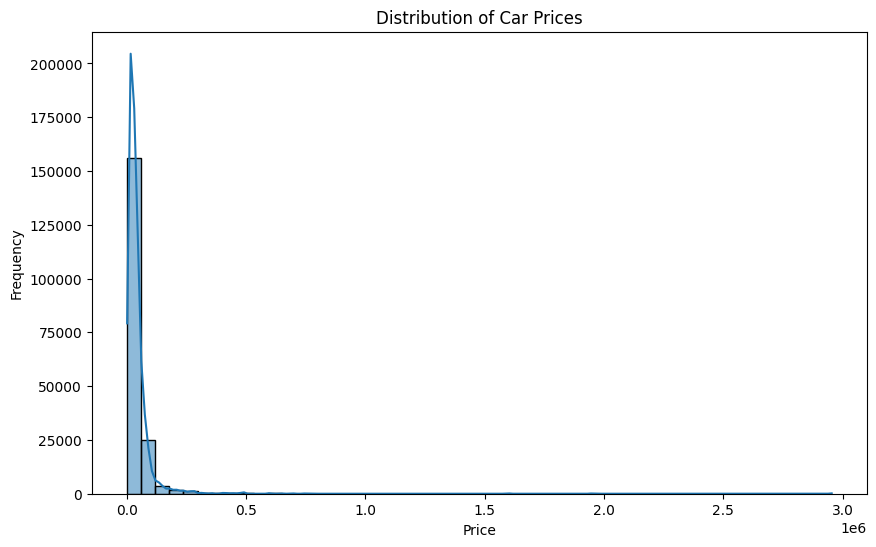

Plotting numerical variables vs price


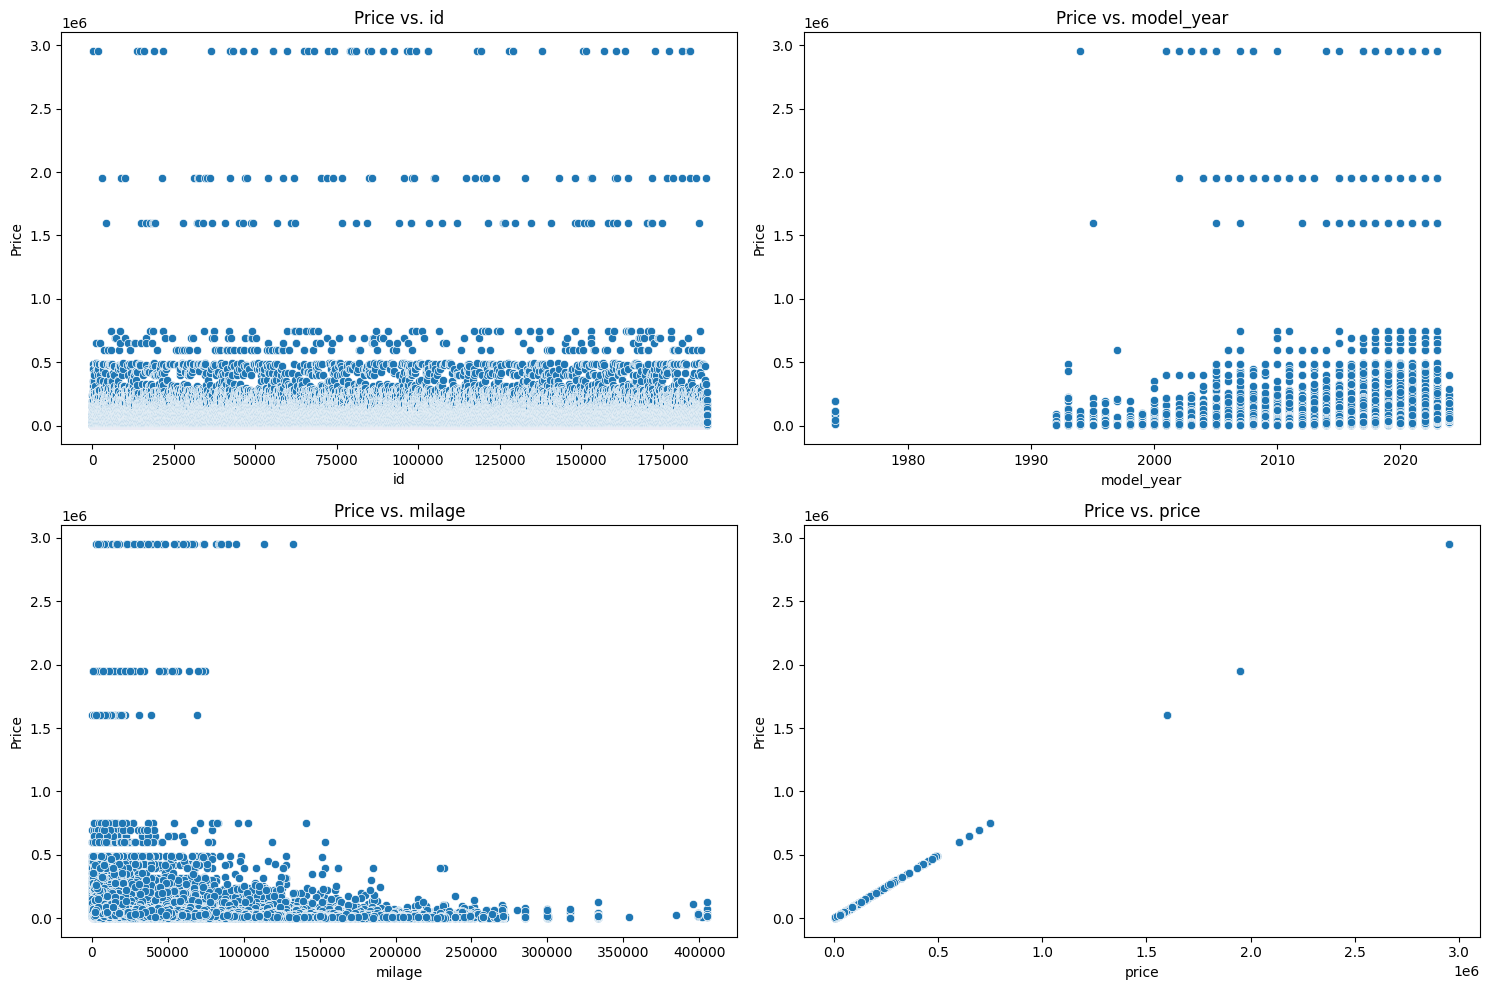

In [ ]:
exploratory_data_analysis(train_df)

In [ ]:
def fill_missing_categorical(df):
    # Automatically find categorical columns with missing values
    categorical_cols = df.select_dtypes(include='object').columns
    missing_cols = [col for col in categorical_cols if df[col].isnull().sum() > 0]

    for col in missing_cols:
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)
        print(f"Filled missing values in '{col}' with mode: {mode_value}")

    print("Categorical missing values handled.")
    return df

In [ ]:
def encode_categorical_columns(df):
    le = LabelEncoder()


    print('Encoding variables...')
    for col in categorical_cols:

        try:
            if df[col].isnull().any():
                df[col].fillna('missing', inplace=True)


            df[col] = le.fit_transform(df[col])
            print(f"Successfully applied Label Encoding to: {col}")
        except Exception as e:
            print(f"Could not apply Label Encoding to {col}. Error: {e}")
    return df

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

# Custom transformer for Label Encoding
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.encoders = {col: LabelEncoder().fit(X[col]) for col in X.columns}
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for col, encoder in self.encoders.items():
            X_encoded[col] = encoder.transform(X_encoded[col])
        return X_encoded

# Main preprocessing function
def build_preprocessing_pipeline(df, model_type='linear'):
    # Separate features, handle 'price' column existence for test set
    if 'price' in df.columns:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('price')
        y = df['price']
    else:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
        y = None # No target variable for the test set

    categorical_cols = df.select_dtypes(include='object').columns

    # Imputers
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='constant', fill_value='unknown')

    # Transformers
    scaler = StandardScaler()
    if model_type == 'linear':
        cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    else:
        cat_encoder = LabelEncoderTransformer()

    # ColumnTransformer
    if model_type == 'linear':
        preprocessor = ColumnTransformer(transformers=[
            ('num', Pipeline([('imputer', num_imputer), ('scaler', scaler)]), numerical_cols),
            ('cat', Pipeline([('imputer', cat_imputer), ('encoder', cat_encoder)]), categorical_cols)
        ])
        X = df.drop(columns=['price'] if 'price' in df.columns else [])
        X_processed = preprocessor.fit_transform(X)
    else:
        # For tree-based models, we apply label encoding after imputation manually
        # Impute categorical and numerical columns
        df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
        df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

        # Apply label encoding to categorical columns
        df[categorical_cols] = LabelEncoderTransformer().fit_transform(df[categorical_cols])


        X_processed = df.drop(columns=['price'] if 'price' in df.columns else [])


    return X_processed, y

In [ ]:
def preprocessing(df):

    df=filling_missing_values_in_numerical_columns(df)
    df=filling_missing_values_in_categorical_columns(df)
    df=encode_categorical_columns(df)


    return df

In [ ]:
X_train_processed, y_train = build_preprocessing_pipeline(train_df, model_type='tree')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            188533 non-null  float64
 1   brand         188533 non-null  int64  
 2   model         188533 non-null  int64  
 3   model_year    188533 non-null  float64
 4   milage        188533 non-null  float64
 5   fuel_type     188533 non-null  int64  
 6   engine        188533 non-null  int64  
 7   transmission  188533 non-null  int64  
 8   ext_col       188533 non-null  int64  
 9   int_col       188533 non-null  int64  
 10  accident      188533 non-null  int64  
 11  clean_title   188533 non-null  int64  
 12  price         188533 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 18.7 MB


In [ ]:
X_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            188533 non-null  float64
 1   brand         188533 non-null  int64  
 2   model         188533 non-null  int64  
 3   model_year    188533 non-null  float64
 4   milage        188533 non-null  float64
 5   fuel_type     188533 non-null  int64  
 6   engine        188533 non-null  int64  
 7   transmission  188533 non-null  int64  
 8   ext_col       188533 non-null  int64  
 9   int_col       188533 non-null  int64  
 10  accident      188533 non-null  int64  
 11  clean_title   188533 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 17.3 MB


In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_val, y_train, y_val = train_test_split(X_train_processed, y_train, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")


Training set size: 150826
Validation set size: 37707


In [ ]:
print(X_train_processed.head())

    id  brand  model  model_year    milage  fuel_type  engine  transmission  \
0  0.0     31    495      2007.0  213000.0          2     116            38   
1  1.0     28    930      2002.0  143250.0          2     366            38   
2  2.0      9   1575      2002.0  136731.0          1     640            38   
3  3.0     16    758      2017.0   19500.0          2     863            49   
4  4.0     36   1077      2021.0    7388.0          2     259            23   

   ext_col  int_col  accident  clean_title  
0      312       71         1            0  
1      263       10         0            0  
2       38       71         1            0  
3       29       14         1            0  
4       29       10         1            0  


# Training your Model

In [ ]:
def train_with_cv(estimator, param_grid, X, y, cv_splits=5, scoring=None):
    if scoring is None:
        scoring = make_scorer(mean_squared_error, squared=False)

    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.cv_results_

In [ ]:
model=RandomForestRegressor()
#model.fit(X_train,y_train)
param_grid = {
    'n_estimators': [500],
    'max_depth': [20],
    'min_samples_split': [50],
    'min_samples_leaf': [50],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'random_state': [42]
}

best_model, best_params, cv_results = train_with_cv(model, param_grid, X_train, y_train)

print("Best Params:", best_params)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Best Params: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 500, 'random_state': 42}


In [ ]:
print(best_model)
print(best_params)

LinearRegression(n_jobs=1)
{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1}


In [ ]:
import joblib

# Save the model
joblib.dump(best_model, 'Submission7.pkl')
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = best_model.predict(X_val)

# Calculate RMSE by taking the square root of the mean squared error
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("Validation RMSE:", val_rmse)

Validation RMSE: 69374.46902783483


In [ ]:
submission6_rsme =67869.76924475763 #Best Params: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 500, 'random_state': 42}



In [ ]:
final_model = RandomForestRegressor(**best_params)

final_model.fit(
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val])
)



RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=50,
                      min_samples_split=50, n_estimators=500, random_state=42)

In [ ]:
test=pd.read_csv("/content/drive/MyDrive/AWIBI/test.csv")
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [ ]:
X_test, _ = build_preprocessing_pipeline(test.copy(), model_type='tree')
X_test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533.0,26,1388,2015.0,98000.0,2,326,16,302,10,1,0
1,188534.0,26,1375,2020.0,9142.0,3,787,31,261,14,1,0
2,188535.0,14,636,2022.0,28121.0,2,541,3,302,57,1,1
3,188536.0,3,182,2016.0,61258.0,2,193,39,259,14,1,1
4,188537.0,3,181,2018.0,59000.0,2,365,38,127,14,1,0


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            125690 non-null  float64
 1   brand         125690 non-null  int64  
 2   model         125690 non-null  int64  
 3   model_year    125690 non-null  float64
 4   milage        125690 non-null  float64
 5   fuel_type     125690 non-null  int64  
 6   engine        125690 non-null  int64  
 7   transmission  125690 non-null  int64  
 8   ext_col       125690 non-null  int64  
 9   int_col       125690 non-null  int64  
 10  accident      125690 non-null  int64  
 11  clean_title   125690 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 11.5 MB


In [ ]:
y_test_pred = final_model.predict(X_test)
y_test_pred[0:5]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


array([18511.26632341, 92960.38762431, 69059.15682535, 26256.57089505,
       29947.2625819 ])

In [ ]:
submission=pd.DataFrame({"id":X_test['id'],"Price":y_test_pred})
submission.to_csv("Submission7.csv",index=False)

In [ ]:
pd.read_csv("Submission7.csv")

,id,Price
0,188533.0,18511.266323
1,188534.0,92960.387624
2,188535.0,69059.156825
3,188536.0,26256.570895
4,188537.0,29947.262582
...,...,...
125685,314218.0,30377.742379
125686,314219.0,70688.842443
125687,314220.0,23585.620402
125688,314221.0,16922.900943
